In [1]:
import sys
sys.path.append("..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import boxcox, pearsonr
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from joblib import Parallel, delayed, parallel_backend
# from statsmodels.sandbox.tools import cross_val
import gc
import scipy.io as sio
from scipy.stats import zscore
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import cohen_kappa_score, auc, confusion_matrix
# from modeldb.sklearn_native import CrossValidationScore
from sklearn.model_selection import GridSearchCV
import traceback
import math

from sklearn.model_selection import cross_val_score
from coh_tools import *
%matplotlib notebook

# style.use("seaborn-colorblind")
style.use("tableau-colorblind10")

In [2]:
# Get experiment info
os.chdir("/home/julien/school/lab/oe_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pd.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]


In [3]:
experiments

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0    Experiment1  MonkeyG  20150908  Session2     M1   
1    Experiment2  MonkeyG  20150908  Session3     M1   
2    Experiment3  MonkeyG  20150908  Session4     M1   
3    Experiment4  MonkeyG  20150909  Session2     M1   
4    Experiment5  MonkeyG  20150909  Session3     M1   
..           ...      ...       ...       ...    ...   
64  Experiment65  MonkeyJ  20160627  Session2     S1   
65  Experiment66  MonkeyJ  20160630  Session1     S1   
66  Experiment67  MonkeyJ  20160630  Session3     S1   
67  Experiment68  MonkeyJ  20160702  Session2     S1   
68  Experiment69  MonkeyJ  20160702  Session4     S1   

                           File Name  stim_Coh_from  stim_Coh_to  \
0   MonkeyG_20150908_Session2_M1.zip             46           63   
1   MonkeyG_20150908_Session3_M1.zip             48           43   
2   MonkeyG_20150908_Session4_M1.zip             48           16   
3   MonkeyG_20150909_Session2_M1.zip             48           12   
4   MonkeyG_20150909_Session3_M1.zip             53           27   
..                               ...            ...          ...   
64  MonkeyJ_20160627_Session2_S1.zip             39           14   
65  MonkeyJ_20160630_Session1_S1.zip             62           55   
66  MonkeyJ_20160630_Session3_S1.zip             58           63   
67  MonkeyJ_20160702_Session2_S1.zip             50           37   
68  MonkeyJ_20160702_Session4_S1.zip             44           64   

    Number of Lasers in Experiment  Number of Lasers during Conditioning  \
0                                2                                     2   
1                                2                                     2   
2                                2                                     2   
3                                2                                     2   
4                                2                                     2   
..                             ...                                   ...   
64                               2                                     2   
65                               2                                     2   
66                               2                                     2   
67                               2                                     2   
68                               2                                     2   

    Delay                       keyname   one   two  doubles  singles  
0    10ms  MonkeyG_20150908_Session2_M1  True  True     True    False  
1    10ms  MonkeyG_20150908_Session3_M1  True  True     True    False  
2    10ms  MonkeyG_20150908_Session4_M1  True  True     True    False  
3    10ms  MonkeyG_20150909_Session2_M1  True  True     True    False  
4    10ms  MonkeyG_20150909_Session3_M1  True  True     True    False  
..    ...                           ...   ...   ...      ...      ...  
64  100ms  MonkeyJ_20160627_Session2_S1  True  True     True    False  
65  100ms  MonkeyJ_20160630_Session1_S1  True  True     True    False  
66   10ms  MonkeyJ_20160630_Session3_S1  True  True     True    False  
67   10ms  MonkeyJ_20160702_Session2_S1  True  True     True    False  
68  100ms  MonkeyJ_20160702_Session4_S1  True  True     True    False  

[69 rows x 16 columns]

## Regression analysis

In [6]:
multiband_allcon_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_allcon_phase_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_phase_dict.pkl", "rb"))

# multiband_allcon_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_dict.pkl", "rb"))
# multiband_allcon_phase_dict = pkl.load(open(r"C:\Users\julienb\lab\data\pickled\multiband_timefreq_allcon_phase_dict.pkl", "rb"))


In [7]:
multiband_allcon_dict.keys()

dict_keys(['theta', 'beta', 'gamma', 'high_gamma'])

In [8]:
ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = "/home/julien/school/lab/oe_data_analysis/csvs/")
# ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = r"C:\Users\julienb\lab\oe_data_analysis\csvs/")

def get_distance(electrode_a, electrode_b): # Indexing is 1 - 96
    if min(electrode_a, electrode_b) <= 0:
#         print("Electrode indexing starts from 1")
#         return
        return 0
    return ((ecog_map[0][electrode_a-1]  - ecog_map[0][electrode_b-1])**2 + (ecog_map[1][electrode_a-1]  - ecog_map[1][electrode_b-1])**2)**.5

# Flattens same way as np flatten()
def get_distances_multi(electrode_list_a, electrode_list_b=[]):
    electrode_list_b = np.array(electrode_list_b).astype(int)
    electrode_list_a = np.array(electrode_list_a).astype(int)
    if not electrode_list_b.any():
        electrode_list_b = electrode_list_a
    distances = []
    for electrode_a in electrode_list_a:
        for electrode_b in electrode_list_b:
            distances.append(get_distance(electrode_a, electrode_b))
    return distances
    # still need to implement unflattened

    def concatenator(lists):
        new_lists = []
        for list_ind in lists:
            new_lists.append(np.asarray(np.concatenate(list_ind)).flatten())
        return new_lists

In [9]:
bad_channels = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/bad_channels.pkl", "rb"))
# bad_channels = pkl.load(open(r"C:\Users\julienb\lab\oe_data_analysis\pickled\bad_channels.pkl", "rb"))

In [10]:
good_channels = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/good_channels.pkl", "rb"))
# good_channels = pkl.load(open(r"C:\Users\julienb\lab\oe_data_analysis\pickled\good_channels.pkl", "rb"))

In [11]:
m1_data = pd.read_csv('M1_sites.csv')
s1_data = pd.read_csv('S1_sites.csv')

# Fit models with various CV splits

In [18]:
## Generate dataframe
## Do Stats ##
dataframes = {}
for band in ["theta", "beta", "gamma", "high_gamma"]:
# for band in ["theta"]:

    print(band)

    data_dict = multiband_allcon_dict[band]
    phase_dict = multiband_allcon_phase_dict[band]

    phasemeans = []
    condmeans = []
    basemeans = []
    newbasemeans = []
    delays = []
    deltacohs = []
    distances = []
    num_lasers = []
    coherence_projections = []
    block_nums = []
    distances_to_a1 = []
    distances_to_b1 = []
    distances_to_a2 = []
    distances_to_b2 = []
    experiment_block_keys = []
    pc1a = []
    pc2a = []
    pc1b = []
    pc2b = []
    monkeys = []
    both_m1 = []
    both_s1 = []
    
    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if (exp_num_laser == 0 or (row["stim_Coh_from"] == 0 and row["stim_Coh_to"] == 0)):
#             print(key)
            continue

        exp_good_channels = good_channels[key[:-3]]
        distancelist = get_distances_multi(exp_good_channels)

        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
        distance_to_a1_list = get_distances_multi(exp_good_channels, a_list)
        distance_to_b1_list = get_distances_multi(exp_good_channels, b_list)
        distance_to_a2_list = get_distances_multi(a_list, exp_good_channels)
        distance_to_b2_list = get_distances_multi(b_list, exp_good_channels)
        monkey_list = [key[6]]*len(distancelist)
        exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser
        m1_exp_data, s1_exp_data = get_m1_s1_matrices(m1_data, s1_data, good_channels, key[:-3])

        try:
            exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
        except:
#                     print("yeet")
            exp_delay_list = np.zeros(len(distancelist))

        for block_num in np.arange(6)+1:                                        
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            if block_num < 6:
                block_base_data = data_dict[rec_key].mean(0)
                basemeans.append(block_base_data.flatten())
                phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                condmeans.append(data_dict[stim_key].mean(0).flatten())
                coherence_projections.append(np.dot(block_base_data, block_base_data).flatten())
                distances.append(distancelist)
                distances_to_a1.append(distance_to_a1_list)
                distances_to_b1.append(distance_to_b1_list)
                distances_to_a2.append(distance_to_a2_list)
                distances_to_b2.append(distance_to_b2_list)
                num_lasers.append(exp_num_laser_list)
                delays.append(exp_delay_list)
                block_nums.append(block_num*np.ones(len(distancelist)))
                experiment_block_keys.append([stim_key]*len(distancelist))
                both_m1.append(m1_exp_data.flatten())
                both_s1.append(s1_exp_data.flatten())

                if block_num == 1:
                    scaler = StandardScaler()
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)
                ## Need to fix this PCA stuff so I have one for each electrode
                pca_data = pca.transform(scaler.transform(block_base_data))
                pc1a.append(np.repeat(pca_data[:, 0], pca_data.shape[0]))
                pc2a.append(np.repeat(pca_data[:, 1], pca_data.shape[0]))
                pc1b.append(np.tile(pca_data[:, 0], pca_data.shape[0]))
                pc2b.append(np.tile(pca_data[:, 1], pca_data.shape[0]))
#                 experiment_keys.append([key]*)
                monkeys.append(monkey_list)

                
            if block_num > 1:
                newbasemeans.append(data_dict[rec_key].mean(0).flatten())

#     lists_to_concat = [phasemeans, distances, distances_to_a1, distances_to_b1, distances_to_a2
#                       distances_to_b2, basemeans, newbasemeans, condmeans, num_lasers,
#                       coherence_projections, delays, block_nums, pc1a, pc2a, pc1b, pc2b]
#     for list_i in lists_to_concat:
#         lists_to_concat[list_i] = np.asarray(np.concatenate(lists_to_concat[list_i])).flatten()
    phasemeans = np.asarray(np.concatenate(phasemeans)).flatten()
    distances = np.asarray(np.concatenate(distances)).flatten()
    distances_to_a1 = np.asarray(np.concatenate(distances_to_a1)).flatten()
    distances_to_b1 = np.asarray(np.concatenate(distances_to_b1)).flatten()
    distances_to_a2 = np.asarray(np.concatenate(distances_to_a2)).flatten()
    distances_to_b2 = np.asarray(np.concatenate(distances_to_b2)).flatten()
    basemeans = np.asarray(np.concatenate(basemeans)).flatten()
    newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
    condmeans = np.asarray(np.concatenate(condmeans)).flatten()
    num_lasers = np.asarray(np.concatenate(num_lasers)).flatten()
    coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
    delays = np.asarray(np.concatenate(delays)).flatten()
    block_nums = np.asarray(np.concatenate(block_nums)).flatten()
    pc1a = np.asarray(np.concatenate(pc1a)).flatten()
    pc2a = np.asarray(np.concatenate(pc2a)).flatten()
    pc1b = np.asarray(np.concatenate(pc1b)).flatten()
    pc2b = np.asarray(np.concatenate(pc2b)).flatten()
    monkeys = np.asarray(np.concatenate(monkeys)).flatten()
    experiment_block_keys = np.asarray(np.concatenate(experiment_block_keys)).flatten()
    both_m1 = np.asarray(np.concatenate(both_m1)).flatten()
    both_s1 = np.asarray(np.concatenate(both_s1)).flatten()

    cond_diff_Y = condmeans - basemeans
    cond_diff_percent_Y = (condmeans - basemeans)/basemeans
#     bc_cond_diff_percent_Y = boxcox(cond_diff_percent_Y-min(cond_diff_percent_Y)+.0001)[0]

    diff_Y = newbasemeans - basemeans
    diff_percent_Y = (newbasemeans - basemeans)/basemeans

    data = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
                        "Coh_proj": coherence_projections, "Phase": phasemeans,
                        "Distance_to_A1": distances_to_a1, "Distance_to_B1": distances_to_b1,
                        "Distance_to_A2": distances_to_a2, "Distance_to_B2": distances_to_b2,
                        "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b})
    scaler = StandardScaler()
    data_scaled = data #pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
    data_scaled["Num_lasers"] = num_lasers
    data_scaled["Delays"] = delays
    data_scaled["Distance_to_A1"] = distances_to_a1
    data_scaled["Distance_to_B1"] = distances_to_b1
    data_scaled["Distance_to_A2"] = distances_to_a2
    data_scaled["Distance_to_B2"] = distances_to_b2
    data_scaled = pd.DataFrame(scaler.fit_transform(data_scaled), columns = data.columns)
    data_scaled["Monkeys"] = monkeys
    data_scaled["Block_num"] = block_nums
    data_scaled["Experiment_block_key"] = experiment_block_keys
    data_scaled["Both_M1"] = both_m1
    data_scaled["Both_S1"] = both_s1

    data_scaled["cond_diff_Y"] = cond_diff_Y  
    data_scaled["cond_diff_percent_Y"] = cond_diff_percent_Y
    data_scaled["diff_Y"] = diff_Y
    data_scaled["diff_percent_Y"] = diff_percent_Y
        
    dataframes[band] = data_scaled
    
    del(data)
    del(data_scaled)
    

theta
beta
gamma
high_gamma


## Data distribution

In [19]:
# from scipy.stats import skew

# for band in ["theta", "beta", "gamma", "high_gamma"]:
# #     plt.hist(dataframes[band]["cond_diff_Y"], bins=30)
#     sns.kdeplot(dataframes[band]["cond_diff_Y"])
#     plt.text(.35, 10-2, "SD: "+str(dataframes[band]["cond_diff_Y"].std())[:5])
#     plt.text(.35, 11.5-2, "Mean: "+str(dataframes[band]["cond_diff_Y"].mean())[:5])
#     plt.text(.35, 8.5-2, "Skew: "+str(skew(dataframes[band]["cond_diff_Y"]))[:5])
    
#     df_sign = np.sign(dataframes[band]["cond_diff_Y"])
#     ((df_sign.sum() / len(df_sign))+1)/2
#     plt.text(.35, 7-2, "P(+): "+str(((df_sign.sum() / len(df_sign))+1)/2)[:5])
#     plt.title("Control coh diff during stim: "+band)
#     plt.show()

In [20]:
dataframes[band].head()

Initial_coh  Distance  Coh_proj     Phase  Distance_to_A1  Distance_to_B1  \
0     3.152792 -1.921541 -0.371724 -0.871023        0.164445        1.756942   
1     2.118511  0.867503 -0.297580 -0.851861        0.164445        1.756942   
2     1.553628  0.315899 -0.288719 -0.817610        0.164445        1.756942   
3     0.494189  0.908622 -0.318727 -0.813728        0.164445        1.756942   
4     0.328011  0.366950 -0.316309 -0.636579        0.164445        1.756942   

   Distance_to_A2  Distance_to_B2      PC1a    PC2a  ...    Delays  Monkeys  \
0        0.164445        1.833010 -0.877527  0.8908  ... -0.527914        G   
1        0.344246        0.657013 -0.877527  0.8908  ... -0.527914        G   
2       -0.078024        0.657013 -0.877527  0.8908  ... -0.527914        G   
3        0.164445        0.407180 -0.877527  0.8908  ... -0.527914        G   
4       -0.301975        0.407180 -0.877527  0.8908  ... -0.527914        G   

   Block_num                     Experiment_block_key Both_M1  Both_S1  \
0        1.0  MonkeyG_20150908_Session2_M1_CondBlock1     1.0      0.0   
1        1.0  MonkeyG_20150908_Session2_M1_CondBlock1     1.0      0.0   
2        1.0  MonkeyG_20150908_Session2_M1_CondBlock1     1.0      0.0   
3        1.0  MonkeyG_20150908_Session2_M1_CondBlock1     1.0      0.0   
4        1.0  MonkeyG_20150908_Session2_M1_CondBlock1     1.0      0.0   

  cond_diff_Y  cond_diff_percent_Y    diff_Y  diff_percent_Y  
0    0.000000             0.000000  0.000000        0.000000  
1    0.087443             0.114833  0.008997        0.011815  
2    0.093183             0.147624 -0.069799       -0.110579  
3    0.160591             0.415076  0.032603        0.084268  
4    0.144176             0.413618  0.041021        0.117683  

[5 rows x 23 columns]

# Do Classification task with regression model

theta


/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the ear

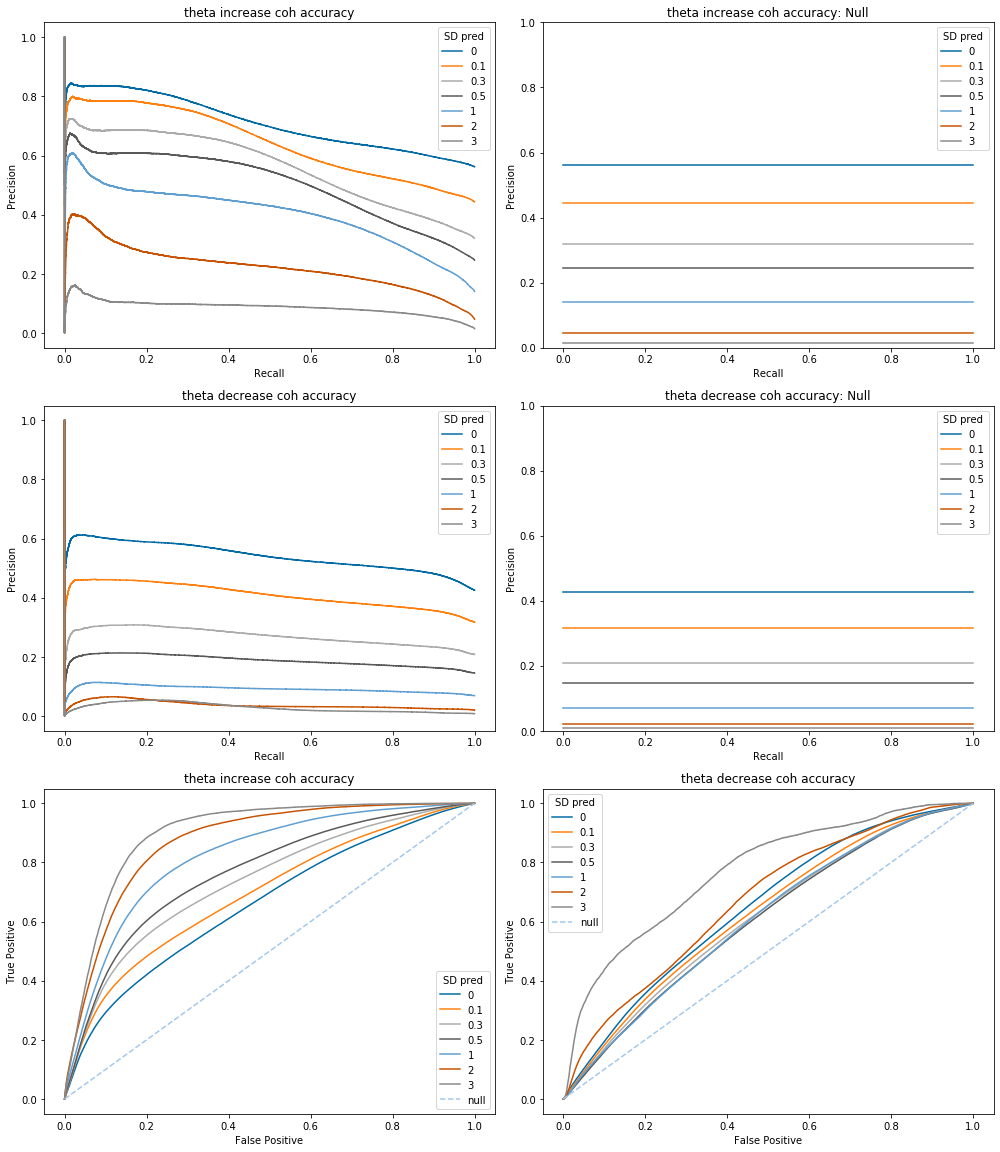

beta


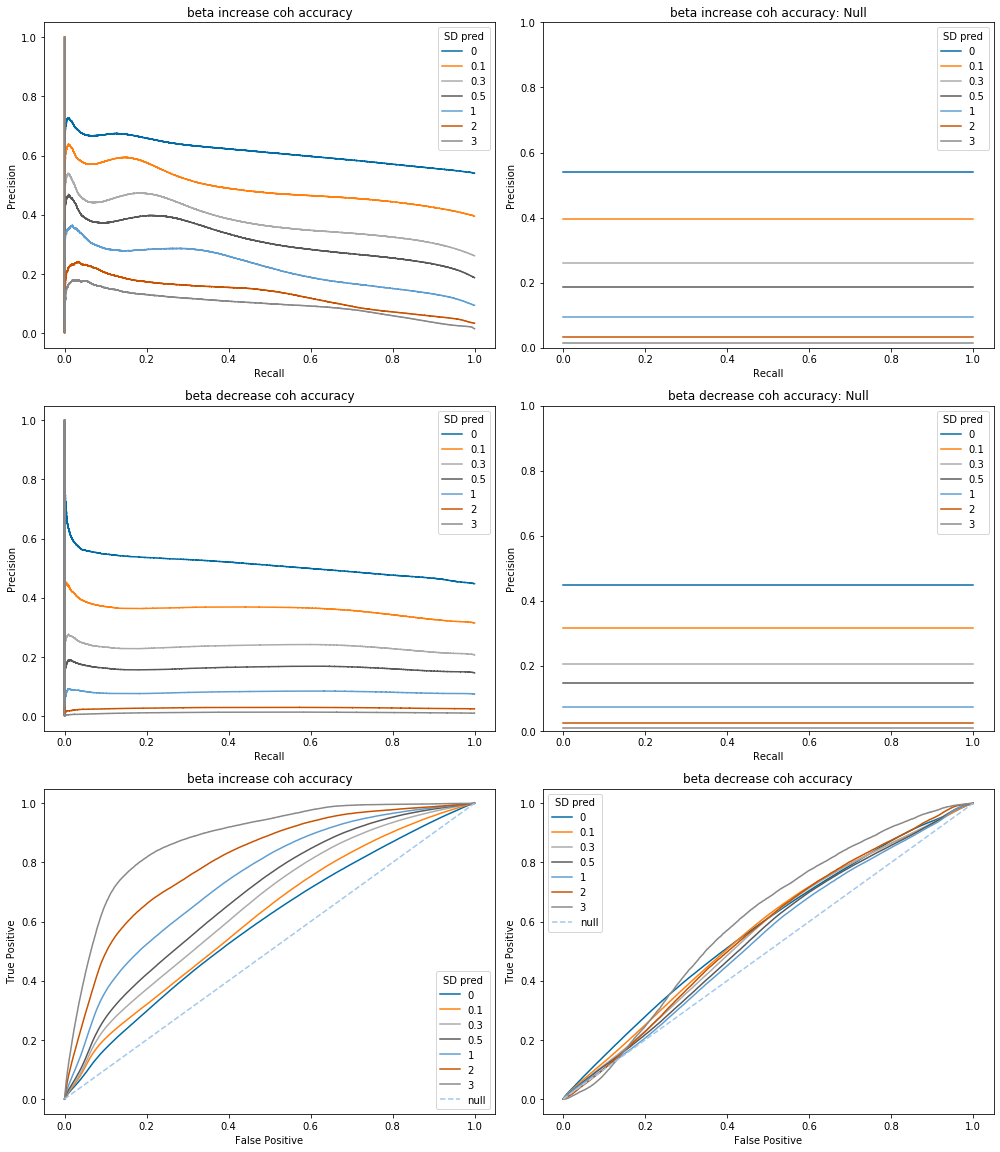

gamma


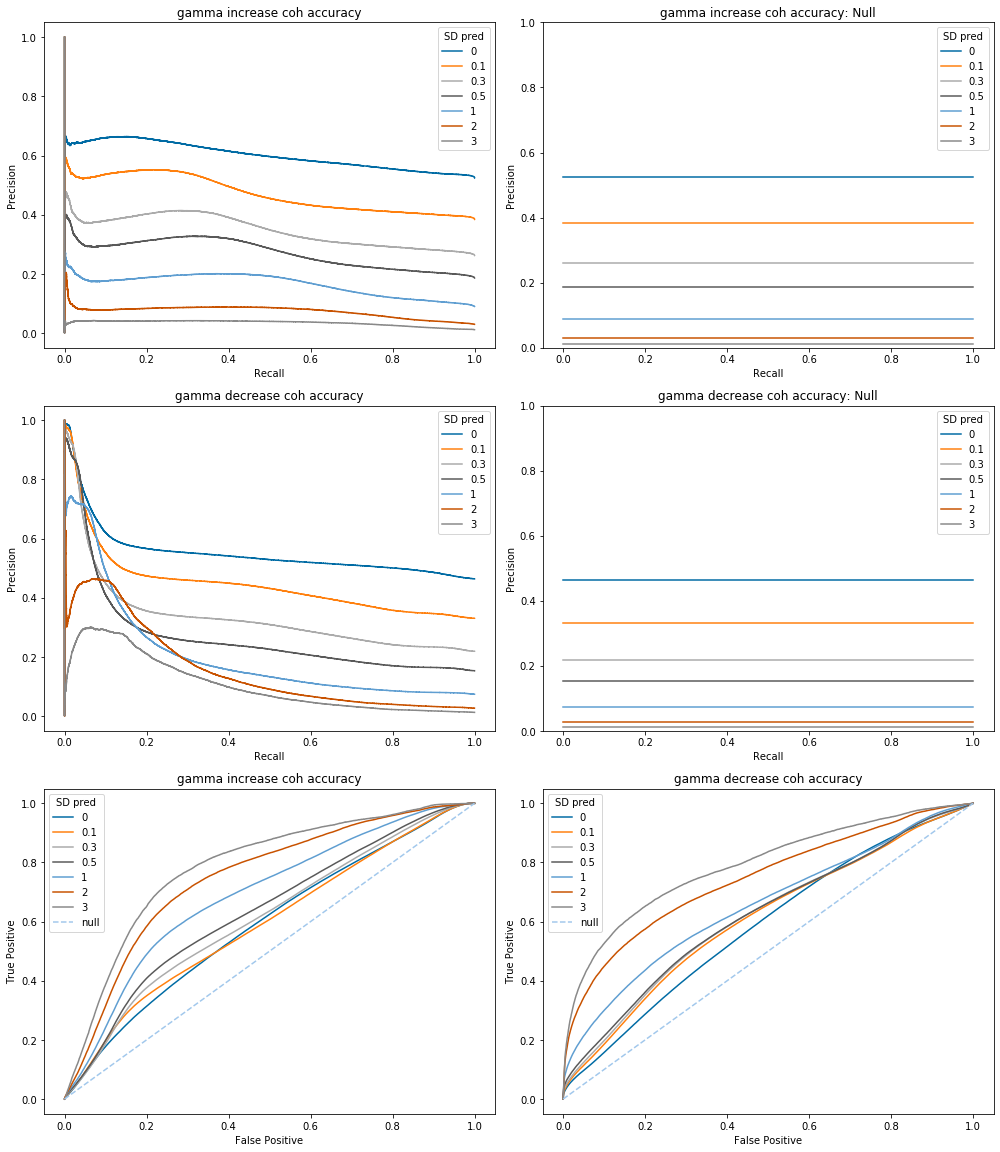

high_gamma


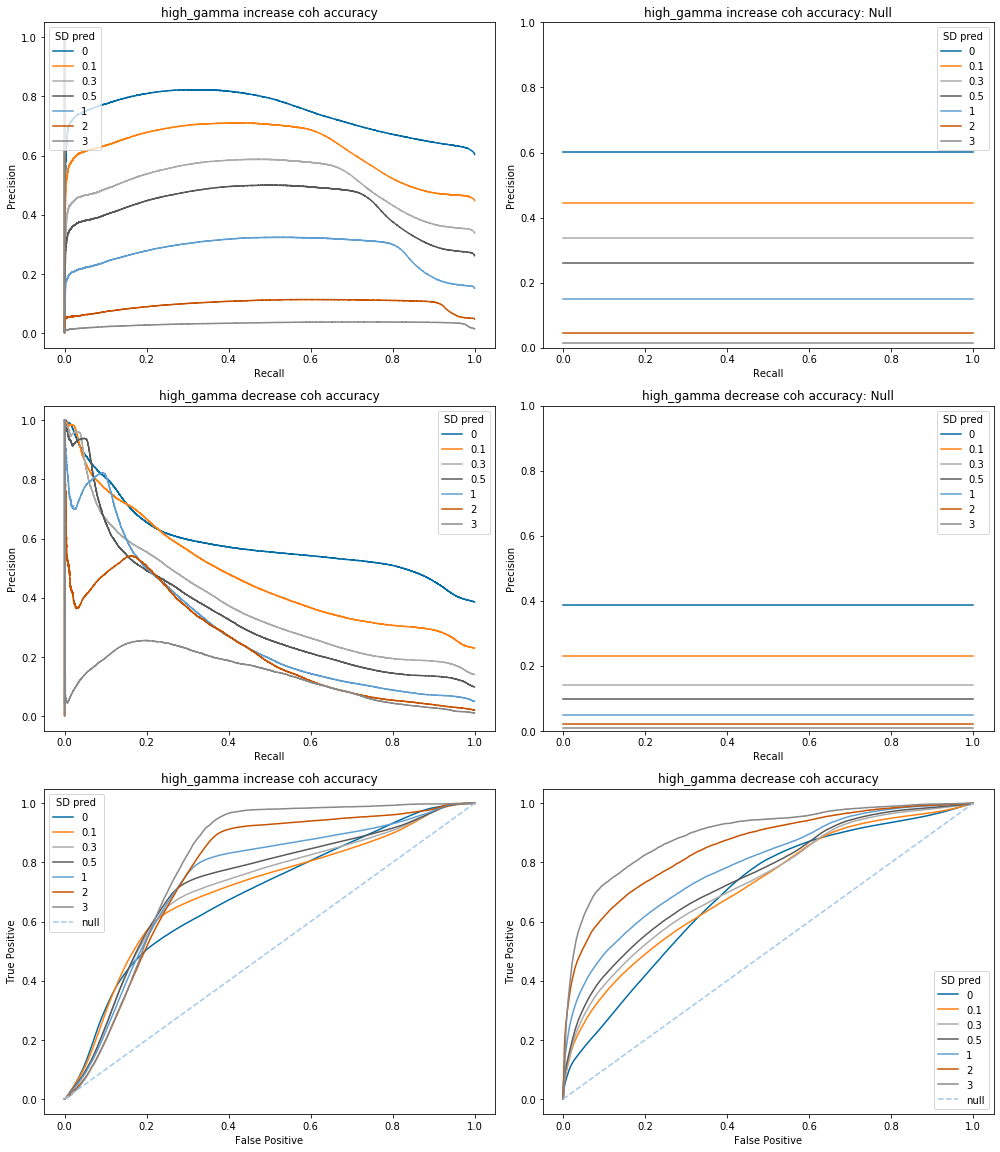

In [12]:
for band in ["theta", "beta", "gamma", "high_gamma"]:

    print(band)
    response = "zdata"

    z_num = 1
    # zdata = zscore(dataframes["theta"]["cond_diff_Y"])
    zdata = dataframes[band]["cond_diff_Y"]
    # zdata_pos = np.where(zdata > z_num, 1, 0)
    # zdata_neg = np.where(zdata < -z_num, 2, 0)
    zdata_class = zdata #_pos + zdata_neg

    dataframes[band]["zdata"] = zdata_class

    cols = dataframes[band].columns
    cols = cols.to_list()
    for col in ["zdata", "cond_diff_percent_Y", "diff_Y", "diff_percent_Y", "cond_diff_Y", "Experiment_block_key"]:
        cols.remove(col)
    if "zdata_class" in cols:
        cols.remove("zdata_class")

    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(cols))
    model = smf.ols(formula, data=dataframes[band]).fit()

    plt.figure(figsize=(14, 21))

    
    for z_factor in [0, .1, .3, .5, 1, 2, 3]:
        z_num = zdata.std() * z_factor
#         print(z_factor)
        
        zdata_pos = np.where(zdata > z_num, 1, 0)
        zdata_neg = np.where(zdata < -z_num, -1, 0)
        zdata_class = zdata_pos + zdata_neg

        z_offset = 0
     # Tweak this parameter for different tests
        preds_data = model.predict(dataframes[band])
        preds_data_pos = np.where(preds_data > z_num+z_offset, 1, 0)
        preds_data_neg = np.where(preds_data < -z_num-z_offset, -1, 0)
        preds_data_class = preds_data_pos + preds_data_neg

#         print("Results for z score over "+str(1)+" with z offset "+str(z_offset))
#         print(cohen_kappa_score(zdata_class, preds_data_class))
#         print(classification_report(zdata_class, preds_data_class))

#         cm = confusion_matrix(zdata_class, preds_data_class, labels=[-1, 0, 1])
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         plt.imshow(cm, cmap="pink_r")
#         plt.xlabel("Pred")
#         plt.ylabel("True")
#         plt.colorbar()

        # %matplotlib notebook
        # plt.figure(figsize=(8, 6))

#         plt.figure()
        prec, rec, threshs = precision_recall_curve(zdata_pos, preds_data) #, drop_intermediate=True)
        plt.subplot(421).plot(rec, prec, alpha=1, label=z_factor) #"Increase") # (auc="+str(auc(tpr, fpr))[:4])
        # plt.twiny().plot(threshs)
        plt.ylabel("Precision") #("True Positive")
        plt.xlabel("Recall") #("False Positive")
        plt.title(band+" increase coh accuracy")
        plt.legend(title="SD pred")

        plt.subplot(422).plot([0, 1], [np.mean(zdata_pos), np.mean(zdata_pos)], label=z_factor) #"Increase") # (auc="+str(auc(tpr, fpr))[:4])
        # plt.twiny().plot(threshs)
        plt.ylabel("Precision") #("True Positive")
        plt.xlabel("Recall") #("False Positive")
        plt.ylim(0, 1)
        plt.title(band+" increase coh accuracy: Null")
        plt.legend(title="SD pred")
        
        prec, rec, threshs = precision_recall_curve(-zdata_neg, -preds_data) #, drop_intermediate=True)
        plt.subplot(423).step(rec, prec, alpha=1, label=z_factor) # (auc="+str(auc(tpr, fpr))[:4])
        plt.ylabel("Precision") #("True Positive")
        plt.xlabel("Recall") #("False Positive")
        plt.title(band+" decrease coh accuracy")
        plt.legend(title="SD pred")
        
        
        plt.subplot(424).plot([0, 1], [-np.mean(zdata_neg), -np.mean(zdata_neg)], label=z_factor) #"Increase") # (auc="+str(auc(tpr, fpr))[:4])
        plt.ylabel("Precision") #("True Positive")
        plt.ylim(0, 1)
        plt.xlabel("Recall") #("False Positive")
        plt.title(band+" decrease coh accuracy: Null")
        plt.legend(title="SD pred")
        

        fpr, tpr, threshs = roc_curve(zdata_pos, preds_data) #, drop_intermediate=True)
        plt.subplot(425).plot(fpr, tpr, alpha=1, label=z_factor) #"Increase") # (auc="+str(auc(tpr, fpr))[:4])
        # plt.twiny().plot(threshs)
        plt.ylabel("True Positive")
        plt.xlabel("False Positive")
#         plt.legend(title="SD pred")
        plt.title(band+" increase coh accuracy")

        fpr, tpr, threshs = roc_curve(-zdata_neg, -preds_data) #, drop_intermediate=True)
        plt.subplot(426).plot(fpr, tpr, alpha=1, label=z_factor) # (auc="+str(auc(tpr, fpr))[:4])
        plt.ylabel("True Positive")
        plt.xlabel("False Positive")
        plt.title(band+" decrease coh accuracy")

#         plt.legend(title="SD pred")
#         plt.show()

    plt.subplot(425).plot([0, 1], [0, 1], alpha=1, label="null", ls="--")
    plt.subplot(425).legend(title="SD pred")
    plt.subplot(426).plot([0, 1], [0, 1], alpha=1, label="null", ls="--")
    plt.subplot(426).legend(title="SD pred")

    plt.tight_layout()
    plt.show()

In [ ]:
break

In [ ]:
np.zeros(33)

In [ ]:
[3].mean

# Make multiple logistic model for 1 z score

In [ ]:
zdata_pos = np.where(zdata > z_num, 1, 0)
zdata_neg = np.where(zdata < -z_num, 2, 0)
zdata_class = zdata_pos + zdata_neg    
dataframes["theta"]["zdata_class"] = zdata_class

cols = dataframes["theta"].columns
cols = cols.to_list()
for col in ["zdata_class", "zdata", "cond_diff_percent_Y", "diff_Y", "diff_percent_Y", "cond_diff_Y", "Experiment_block_key"]:
    cols.remove(col)
    
formula = "{} ~ {} + 1".format("zdata_class",
                               ' + '.join(cols))
log_model = smf.mnlogit(formula, data=dataframes["theta"]).fit()

In [ ]:
log_preds = log_model.predict(dataframes["theta"])
class_log_preds = []
for row in log_preds.iterrows():
    class_log_preds.append(row[1].idxmax())
    
print("Results for z score over "+str(z_num)) #+" with z offset "+str(z_offset))
print(cohen_kappa_score(zdata_class, class_log_preds))
print(classification_report(zdata_class, class_log_preds))

cm = confusion_matrix(zdata_class, class_log_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, cmap="pink_r")
plt.xlabel("Pred")
plt.ylabel("True")
plt.colorbar()

In [ ]:
break

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = dataset.target

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_sample(X, y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Forward regression 

In [ ]:
### Iteratively do regression ###
def forward_selected(data, response, test_data=False, extra_feats=False, startwith=False, want_details=True):
    details = {}
    if type(test_data) != pd.core.frame.DataFrame:
        test_data = data
    remaining = set(data.columns)
    if type(extra_feats) == list:
        remaining.update(extra_feats)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    initial_model = smf.ols("{} ~ 1".format(response), data=data).fit()
    initial_score = r2_score(test_data[response], initial_model.predict(test_data))
    print("Null/intercept r2 is "+str(initial_score)+" with coeff of "+str(initial_model.params[0]))
    details["null"] = [0, initial_score]
    if type(startwith) == list:
        remaining -= set(startwith)
        selected.extend(startwith)
        formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(startwith))
        score = r2_score(test_data[response], smf.ols(formula, data).fit().predict(test_data))
        print("With given feat "+str(startwith)+": "+str(score))
    i = 1
    while remaining:
#         print(str(len(remaining))+" feats left")
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            candidate_model = smf.ols(formula, data).fit()
            score = r2_score(test_data[response], candidate_model.predict(test_data))
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
#         if current_score < best_new_score:
            
        print(best_candidate, best_new_score)
        details[best_candidate] = [i, best_new_score]
        remaining.remove(best_candidate)
        selected.append(best_candidate)
        current_score = best_new_score
        i += 1
#         else:
#             break
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    if want_details:
        return (model, details)
    return model

In [ ]:
# # forward selection with no CV
# f_noCV_band_model_dict = {}
# # for band in ["theta", "beta", "gamma", "high_gamma"]:
# for band in ["beta", "gamma", "high_gamma"]:
#     print(band)
#     band_data = dataframes[band].drop(["cond_diff_Y", "diff_Y", "diff_percent_Y"], axis=1)
#     f_model = forward_selected(band_data, "cond_diff_percent_Y")
#     f_noCV_band_model_dict[band] = f_model
#     print()

In [ ]:
# forward selection with random sample train/test
f_randomCV_band_detail_dict = {"theta":[]} #, "beta":[], "gamma":[], "high_gamma":[]}
for trial_nums in range(10):
    f_randomCV_band_model_dict = {}
    for band in ["theta"]:#, "beta", "gamma", "high_gamma"]:
        print(band)
        band_data = dataframes[band].drop(["cond_diff_percent_Y", "diff_Y", "diff_percent_Y", "Experiment_block_key"], axis=1)

        test_data = band_data.sample(frac=.3)
    #     test_data = test_data.reset_index()
        train_data = band_data.drop(test_data.index)
    #     test_data = test_data.drop("index", axis=1)

        f_model, f_details = forward_selected(train_data, "cond_diff_Y", test_data=test_data, want_details=True)
#         f_randomCV_band_model_dict[band] = f_model
        f_randomCV_band_detail_dict[band].append(f_details)


In [ ]:
# # forward selection with train on 4, test on 5
# f_sessCV_band_model_dict = {}
# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     print(band)
#     band_data = dataframes[band].drop(["cond_diff_Y", "diff_Y", "diff_percent_Y"], axis=1)

#     train_data = band_data.loc[band_data["Block_num"] < 5]
#     test_data = band_data.loc[band_data["Block_num"] >= 5]
    
#     f_model = forward_selected(train_data, "cond_diff_percent_Y", test_data=test_data)
#     f_sessCV_band_model_dict[band] = f_model

In [ ]:
# # forward selection with random sample train/val/test, tuning on val
# f_ttvCV_band_model_dict = {}
# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     print(band)
#     band_data = dataframes[band].drop(["cond_diff_Y", "diff_Y", "diff_percent_Y"], axis=1)
    
#     test_data = band_data.sample(frac=.25)    
#     train_data = band_data.drop(test_data.index)
#     val_data = train_data.sample(frac=.25)
#     train_data = train_data.drop(val_data.index)
    
#     f_model = forward_selected(train_data, "cond_diff_percent_Y", test_data=test_data)
#     f_ttvCV_band_model_dict[band] = f_model

In [ ]:
### Look at results of forward selection
for band, results in f_randomCV_band_detail_dict.items():
    print(band)
    df = pd.DataFrame()
    for detail_dict in results:
        df = pd.concat([df, pd.DataFrame.from_dict(detail_dict).T])
    df["feature"] = df.index
    df = df.reset_index(drop=True)
    df = df.rename(columns={0: "Choice_num", 1: "r2"})
    print("Average num feats (incl. intercept): "+str(df.shape[0]/10))
#     print(df["feature"].value_counts())
    print(df.groupby("feature").mean().sort_values('Choice_num'))
    print()

## Preset forward selection

In [ ]:
### Preset forward selection###
def preset_forward_selected(data, response, order, test_data, extra_feats=False, startwith=False,
                    want_details=True):
    details = {}
    
    selected = []
    
    initial_model = smf.ols("{} ~ 1".format(response), data=data).fit()
    initial_score = r2_score(test_data[response], initial_model.predict(test_data))

    details["null"] = [0, 0, initial_score]
    for next_choice_i, next_choice in enumerate(order):
        formula = "{} ~ {} + 1".format(response,
                                       ' + '.join(selected + [next_choice]))
        candidate_model = smf.ols(formula, data).fit()
        train_score = r2_score(data[response], candidate_model.predict(data)) # candidate_model.rsquared
#         print(test_data[response].mean())
        test_score = r2_score(test_data[response], candidate_model.predict(test_data))
        details[next_choice] = [next_choice_i, train_score, test_score]
        selected.append(next_choice)

    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = "no" #smf.ols(formula, data).fit()
    if want_details:
        return (model, details)
    return model

In [ ]:
# # Do the actual PRESET forward selection with random sample train/test
# preset_randomCV_band_detail_dict = {"theta":[]} #, "beta":[], "gamma":[], "high_gamma":[]}

# order = list(df.groupby("feature").mean().sort_values('Choice_num').index)
# order.remove("null")

# for band in ["theta"]: #, "beta", "gamma", "high_gamma"]:
#     for trial_nums_i in tqdm(range(150)):
        
        
#     ### Train validation test split ###
#     train, test = train_test_split(dataframes[band], test_size=0.2)
#     kf = KFold(5, shuffle=True)
#     train_index, val_index = kf_i
#     k_train, k_val = train.iloc[train_index], train.iloc[val_index]
#     data_train = pd.DataFrame(data=k_train, columns=dataframes[band].columns)
#     data_val = pd.DataFrame(data=k_val, columns=dataframes[band].columns)
        
        
# #         print(band)
#         band_data = dataframes[band].drop(["cond_diff_percent_Y", "diff_Y", "diff_percent_Y"], axis=1)

# #         test_data = band_data.sample(frac=.5)
# #         train_data = band_data.drop(test_data.index)

#         f_model, f_details = preset_forward_selected(train_data, "cond_diff_Y", order, test_data=test_data, want_details=True)
# #         f_randomCV_band_model_dict[band] = f_model
#         preset_randomCV_band_detail_dict[band].append(f_details)


In [ ]:
# Do the actual PRESET forward selection with k folds
preset_randomCV_band_detail_dict = {"theta":[]} #, "beta":[], "gamma":[], "high_gamma":[]}

order = list(df.groupby("feature").mean().sort_values('Choice_num').index)
order.remove("null")

for band in ["theta"]: #, "beta", "gamma", "high_gamma"]:
### Train validation test split ###
    kfs = KFold(20, shuffle=True)
    for i, kf in enumerate(kfs.split(dataframes[band])):
        train_index, test_index = kf
        k_train, k_test = dataframes[band].iloc[train_index], dataframes[band].iloc[test_index]

        data_train = pd.DataFrame(data=k_train, columns=dataframes[band].columns).drop(["cond_diff_percent_Y", "diff_Y", "diff_percent_Y"], axis=1)
        data_test = pd.DataFrame(data=k_test, columns=dataframes[band].columns).drop(["cond_diff_percent_Y", "diff_Y", "diff_percent_Y"], axis=1)

        f_model, f_details = preset_forward_selected(train_data, "cond_diff_Y", order, test_data=test_data, want_details=True)
        preset_randomCV_band_detail_dict[band].append(f_details)
        print("Finished with "+str(i))


In [ ]:
### Look at results of preset forward selection
for band, results in preset_randomCV_band_detail_dict.items():
    print(band)
    df = pd.DataFrame()
    for detail_dict in results:
        df = pd.concat([df, pd.DataFrame.from_dict(detail_dict).T])
    df["feature"] = df.index
    df = df.reset_index(drop=True)
    df = df.rename(columns={0: "Choice_num", 1: "train_r2", 2:"test_r2"})
#     print("Average num feats (incl. intercept): "+str(df.shape[0]/50))
# #     print(df["feature"].value_counts())
    print(df.groupby("feature").median().sort_values("Choice_num"))
    print()

### Fitting the full model

In [ ]:
### Fitting the full model
bands = []
coefs = []
variables = []
errs = []
for band in ["theta"]: #, "beta", "gamma", "high_gamma"]:
    full_model = smf.ols("cond_diff_Y ~ Initial_coh + Monkeys + PC2a + PC2b + Coh_proj + Num_lasers + \
    PC1b + PC1a + Phase + Distance + Block_num + Delays + Distance_to_A2 + Distance_to_A1 + Distance_to_B1 + Distance_to_B2"
                         , data=dataframes[band]).fit()
    err_series = full_model.bse
    
    for i, coef in enumerate(full_model.params.values[1:]):
        coefs.append(coef)
        bands.append(band)
        variables.append(err_series.index.values[1:][i])
        errs.append(err_series.values[1:][i])


In [ ]:
coef_df = pd.DataFrame({"varname": variables, "band": bands, "coef": coefs, "err": errs})
# coef_df = coef_df.sort_values("coef")
pd.pivot_table(coef_df, index = 'varname', columns = 'band', values = 'coef').reindex(["theta", "beta", "gamma", "high_gamma"][::-1],\
            axis=1).plot(figsize=(5, 13), kind = 'barh', xerr=pd.pivot_table(coef_df, index = 'varname', columns = 'band', values = 'err'))
# plt.savefig(r'C:\Users\julienb\lab\oe_data_analysis\figures\all_ols\\'+"allbands_coeff_barplot.pdf")


In [ ]:
print(coef_df[coef_df.band=="theta"])

# Find good blocks and generate predictions

In [ ]:
exp_block_keys = dataframes["theta"].Experiment_block_key.unique()
rs = []
for exp_block_key in exp_block_keys:
    block_data = dataframes["theta"][dataframes["theta"]["Experiment_block_key"] == exp_block_key]
    full_model.predict(block_data)
    rs.append(r2_score(block_data["cond_diff_Y"], full_model.predict(block_data)))
#     break

In [ ]:
sorted_rs_indices = np.argsort(-np.array(rs))

In [ ]:
rs[sorted_rs_indices[0]]

In [ ]:
good_theta_predictions = {}
theta_ground_truth = {}
for good_exp_block in exp_block_keys[sorted_rs_indices][:7]:
    
    block_data = dataframes["theta"][dataframes["theta"]["Experiment_block_key"] == good_exp_block]
    good_theta_predictions[good_exp_block+"_pred"] = full_model.predict(block_data).tolist()
    theta_ground_truth[good_exp_block+"_truth"] = dataframes["theta"][dataframes["theta"]["Experiment_block_key"] == good_exp_block]["cond_diff_Y"].tolist()
    

In [ ]:
#sio.savemat('/home/julien/school/lab/oe_data_analysis/matlab/good_theta_preds_101619.mat', good_theta_predictions)
#sio.savemat('/home/julien/school/lab/oe_data_analysis/matlab/good_theta_truth_101619.mat', theta_ground_truth)
sio.savemat(r'C:\Users\julienb\lab\oe_data_analysis\matlab\good_theta_preds_101719.mat', good_theta_predictions)
sio.savemat(r'C:\Users\julienb\lab\oe_data_analysis\matlab\good_theta_truth_101719.mat', theta_ground_truth)


In [ ]:
### Hand selecting one block
choice_block = "MonkeyG_20150914_Session1_S1_CondBlock4"

choice_theta_predictions = {}
choice_theta_ground_truth = {}
block_data = dataframes["theta"][dataframes["theta"]["Experiment_block_key"] == choice_block]
choice_theta_predictions[choice_block+"_pred"] = full_model.predict(block_data).tolist()
choice_theta_ground_truth[choice_block+"_truth"] = block_data["cond_diff_Y"].tolist()
# block_data
sio.savemat(r'C:\Users\julienb\lab\oe_data_analysis\matlab\choice_preds_101719.mat', choice_theta_predictions)
sio.savemat(r'C:\Users\julienb\lab\oe_data_analysis\matlab\choice_truth_101719.mat', choice_theta_ground_truth)


In [ ]:
break

## Hand model tuning

In [ ]:
for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    band_data = dataframes[band]
    # Removed: PC1a
    ols_interact = smf.ols(formula='cond_diff_Y ~ (Initial_coh + Distance + Phase \
           + Coh_proj + PC2a + PC1b + PC2b + Delays + Distance_to_A1 + Distance_to_B1 \
           + Distance_to_A2 \
           + Distance_to_B2  + Monkeys\
           + Block_num)', data=band_data).fit() #_regularized(alpha=.1, refit=True)
    print(ols_interact.rsquared)
    print(r2_score(band_data["cond_diff_Y"], ols_interact.predict(band_data)))
    print(np.nonzero(ols_interact.params)[0].size)
#     print(ols_interact.summary())
    
    fig = plt.figure(figsize=(10, 22))
    fig = sm.graphics.plot_ccpr_grid(ols_interact, fig=fig)
#     plt.show()
    plt.savefig("/home/julien/school/lab/oe_data_analysis/figures/all_ols/"+band+"partial_alldata.pdf")
    plt.close()
    
    
    
    # train test split
#     train_data = band_data.loc[band_data["Block_num"] < 5]
#     test_data = band_data.loc[band_data["Block_num"] >= 5]
#     test_data = band_data.sample(frac=.2)
#     test_data = test_data.reset_index()
#     train_data = band_data.drop(test_data.index)

#     ols_train_interact = smf.ols('cond_diff_Y ~ (Initial_coh + Distance + Phase \
#            + Coh_proj + PC2a + PC1b + PC2b + Delays + Distance_to_A1 + Distance_to_B1 \
#            + Distance_to_A2 \
#            + Distance_to_B2  + Monkeys\
#            + Block_num)', data=train_data).fit() #_regularized(alpha=.1, refit=True)

#     print(ols_train_interact.rsquared)
#     print(r2_score(test_data["cond_diff_Y"], ols_train_interact.predict(test_data)))
# #     print(np.nonzero(ols_train_interact.params)[0].size)
#     print(ols_train_interact.summary())

    print()
#     rsquareds[band].append(r2_score(test_data["cond_diff_Y"], ols_interact.predict(test_data)))

In [ ]:
test_data

In [ ]:
'cond_diff_percent_Y ~ Initial_coh + Distance + Phase \
                   + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 \
                   + Distance_to_B2 + PC1a + PC2a + PC1b + PC2b + \
                   Delays + (Initial_coh + Distance + Phase \
                   + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 + Distance_to_B2 \
                   + PC1a + PC2a + PC1b + PC2b + Delays)**2'

In [ ]:
for band in ["theta", "beta", "gamma", "high_gamma"]:

    block_Ys = pd.DataFrame({num: dataframes[band].loc[dataframes[band]["Block_num"] == num]["cond_diff_percent_Y"].dropna().reset_index(drop=True) for num in range(1, 6)})
    sns.heatmap(block_Ys.corr(), cmap="YlOrRd")
    plt.title("Correlation of coherence change in "+band+" band")
    plt.show()

### General TVT split with all data

In [ ]:
def cv_scores(kf_i, lam):
    train_index, val_index = kf_i
    k_train, k_val = train.iloc[train_index], train.iloc[val_index]
    data_train = pd.DataFrame(data=k_train, columns=dataframes[band].columns)
    data_val = pd.DataFrame(data=k_val, columns=dataframes[band].columns)

#     ols_percent = smf.ols(formula='cond_diff_percent_Y ~ Initial_coh + Distance + Phase \
#                    + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 \
#                    + Distance_to_B2 + PC1a + PC2a + PC1b + PC2b + \
#                    C(Delays)', data=data_train).fit_regularized(alpha=lam, refit=True)
#     Y_predict = ols_percent.predict(data_val)
#     scores = sm.tools.eval_measures.rmse(Y_predict, data_val["cond_diff_percent_Y"])

#     ols_interact = smf.ols(formula='cond_diff_percent_Y ~ Initial_coh + Distance + Phase \
#                    + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 \
#                    + Distance_to_B2 + PC1a + PC2a + PC1b + PC2b + \
#                    C(Delays) + (Initial_coh + Phase \
#                    + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 \
#                    + PC1a + PC2a + PC1b + PC2b)*C(Delays)', data=data_train).fit_regularized(alpha=lam, refit=True)
#     Y_predict = ols_interact.predict(data_val)
#     scores_interact = sm.tools.eval_measures.rmse(Y_predict, data_val["cond_diff_percent_Y"])


    ols_poly_interact = smf.ols(formula='cond_diff_percent_Y ~ Initial_coh + Distance + Phase \
                   + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 \
                   + Distance_to_B2 + PC1a + PC2a + PC1b + PC2b + \
                   Delays + (Initial_coh + Distance + Phase \
                   + Coh_proj + Block_num + Distance_to_A1 + Distance_to_B1 + Distance_to_A2 + Distance_to_B2 \
                   + PC1a + PC2a + PC1b + PC2b + Delays)**2', data=data_train).fit_regularized(alpha=lam) #, refit=True)
    Y_predict = ols_poly_interact.predict(data_val)
    scores_interact = r2_score(data_val["cond_diff_percent_Y"], Y_predict)
    
#     ols_null = smf.ols(formula='cond_diff_percent_Y ~ 1', data=data_train).fit()
#     Y_predict = ols_null.predict(data_val)
#     scores_null = sm.tools.eval_measures.rmse(Y_predict, data_val["cond_diff_percent_Y"])
    
    train_predict = ols_poly_interact.predict(data_train)
    score_train = r2_score(data_train["cond_diff_percent_Y"], train_predict)

    
    gc.collect()
    return [lam, score_train, scores_interact, ols_poly_interact]



In [ ]:
## Do Stats ##
band_scores = {}
for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    
    ### Train validation test split ###
    train, test = train_test_split(dataframes[band], test_size=0.2)
    kf = KFold(5, shuffle=True)
    
    lambdas = [.00001]
    kf_lambdas = []
    for kf_i in kf.split(train):
        for lambda_i in lambdas:
            kf_lambdas.append([kf_i, lambda_i])
#     band_scores[band] = Parallel(n_jobs=3, verbose=10)(delayed(cv_scores)(kf_lambda[0], kf_lambda[1]) for kf_lambda in kf_lambdas)
    band_scores[band] = [cv_scores(kf_lambdas[kf_lambda_i][0], kf_lambdas[kf_lambda_i][1]) for kf_lambda_i in tqdm(range(len(kf_lambdas)))]


In [ ]:
### Look at results ###

for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    
    models = [row[3] for row in band_scores[band]]
    bs = [row[:3] for row in band_scores[band]]
    bs = np.array(bs)
    score_data = pd.DataFrame({"lambdas": bs[:, 0], "train_rmse": bs[:, 2], "val_rmse": bs[:, 1]})
    
#     sns.pointplot(x="lambdas", y="train_rmse", data=score_data)
#     plt.title(band)
#     plt.show()
    
#     for i, l in enumerate(bs[:6, 0]):
#         if l in [.00001, .01]:
# #             print(l)
#             print(bs[i, 0:3])
# #             print(models[i].summary())

    print(score_data.groupby('lambdas').mean())
    print()
    

## Analyze sessions individually

In [ ]:
## Do Stats ##
rsquareds = {band: [] for band in ["theta", "beta", "gamma", "high_gamma"]}
params = {band: [] for band in ["theta", "beta", "gamma", "high_gamma"]}
theta_exp_list = []
for band in ["theta"]: #, "beta", "gamma", "high_gamma"]:
# for band in ["beta"]:

    print(band)

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
        if exp_num_laser == 0:
            continue

        data_dict = multiband_allcon_dict[band]
        phase_dict = multiband_allcon_phase_dict[band]

        phasemeans = []
        condmeans = []
        basemeans = []
        newbasemeans = []
        delays = []
        deltacohs = []
        distances = []
        num_lasers = []
        coherence_projections = []
        pc1a = []
        pc2a = []
        pc1b = []
        pc2b = []
        block_nums = []
        distances_to_a1 = []
        distances_to_b1 = []
        distances_to_a2 = []
        distances_to_b2 = []


        exp_good_channels = good_channels[key[:-3]]    
        distancelist = get_distances_multi(exp_good_channels)
        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
        distance_to_a1_list = get_distances_multi(exp_good_channels, a_list)
        distance_to_b1_list = get_distances_multi(exp_good_channels, b_list)
        distance_to_a2_list = get_distances_multi(a_list, exp_good_channels)
        distance_to_b2_list = get_distances_multi(b_list, exp_good_channels)
        exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser

        try:
            exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
        except:
#                     print("yeet")
            exp_delay_list = np.zeros(len(distancelist))

        for block_num in np.arange(6)+1:                                        
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            if block_num < 6:
                block_base_data = data_dict[rec_key].mean(0)
                basemeans.append(block_base_data.flatten())
                phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                condmeans.append(data_dict[stim_key].mean(0).flatten())
                coherence_projections.append(np.dot(block_base_data, block_base_data).flatten())
                distances.append(distancelist)
                distances_to_a1.append(distance_to_a1_list)
                distances_to_b1.append(distance_to_b1_list)
                distances_to_a2.append(distance_to_a2_list)
                distances_to_b2.append(distance_to_b2_list)
                num_lasers.append(exp_num_laser_list)
                delays.append(exp_delay_list)
                block_nums.append(block_num*np.ones(len(distancelist)))

                if block_num == 1:
                    scaler = StandardScaler()
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)
                ## Need to fix this PCA stuff so I have one for each electrode
                pca_data = pca.transform(scaler.transform(block_base_data))
                pc1a.append(np.repeat(pca_data[:, 0], pca_data.shape[0]))
                pc2a.append(np.repeat(pca_data[:, 1], pca_data.shape[0]))
                pc1b.append(np.tile(pca_data[:, 0], pca_data.shape[0]))
                pc2b.append(np.tile(pca_data[:, 1], pca_data.shape[0]))

            if block_num > 1:
                newbasemeans.append(data_dict[rec_key].mean(0).flatten())


        phasemeans = np.asarray(np.concatenate(phasemeans)).flatten()
        distances = np.asarray(np.concatenate(distances)).flatten()
        basemeans = np.asarray(np.concatenate(basemeans)).flatten()
        condmeans = np.asarray(np.concatenate(condmeans)).flatten()
        newbasemeans = np.asarray(np.concatenate(newbasemeans)).flatten()
        num_lasers = np.asarray(np.concatenate(num_lasers)).flatten()
        coherence_projections = np.asarray(np.concatenate(coherence_projections)).flatten()
        delays = np.asarray(np.concatenate(delays)).flatten()
        pc1a = np.asarray(np.concatenate(pc1a)).flatten()
        pc2a = np.asarray(np.concatenate(pc2a)).flatten()
        pc1b = np.asarray(np.concatenate(pc1b)).flatten()
        pc2b = np.asarray(np.concatenate(pc2b)).flatten()
        block_nums = np.asarray(np.concatenate(block_nums)).flatten()
        distances_to_a1 = np.asarray(np.concatenate(distances_to_a1)).flatten()
        distances_to_b1 = np.asarray(np.concatenate(distances_to_b1)).flatten()
        distances_to_a2 = np.asarray(np.concatenate(distances_to_a2)).flatten()
        distances_to_b2 = np.asarray(np.concatenate(distances_to_b2)).flatten()

        
        cond_diff_Y = condmeans - basemeans
        cond_diff_percent_Y = (condmeans - basemeans)/basemeans
    #     bc_cond_diff_percent_Y = boxcox(cond_diff_percent_Y-min(cond_diff_percent_Y)+.0001)[0]

        diff_Y = newbasemeans - basemeans
        diff_percent_Y = (newbasemeans - basemeans)/basemeans
    
#         tau = 10
#         delay_curve = np.exp(-np.array(delays)/tau)

#             data = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
#                                 "Coh_proj": coherence_projections, "Phase": phasemeans,
#                                 "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b})


        data = pd.DataFrame({"Initial_coh": basemeans, "Distance": distances,
                    "Coh_proj": coherence_projections, "Phase": phasemeans,
                    "Distance_to_A1": distances_to_a1, "Distance_to_B1": distances_to_b1,
                    "Distance_to_A2": distances_to_a2, "Distance_to_B2": distances_to_b2,
                    "PC1a": pc1a, "PC2a": pc2a, "PC1b": pc1b, "PC2b": pc2b, 
                    })

        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
        data_scaled["Num_lasers"] = num_lasers
#         data_scaled["Y"] = Y
        data_scaled["Delays"] = delays
        data_scaled["Block_num"] = block_nums
        
        data_scaled["cond_diff_Y"] = cond_diff_Y  
        data_scaled["cond_diff_percent_Y"] = cond_diff_percent_Y
        data_scaled["diff_Y"] = diff_Y
        data_scaled["diff_percent_Y"] = diff_percent_Y
        
        # train test split
#         train_data = data_scaled.loc[data_scaled["Block_num"] < 5]
#         test_data = data_scaled.loc[data_scaled["Block_num"] >= 5]

    full_model = smf.ols("cond_diff_percent_Y ~ Initial_coh + Monkeys + PC2a + PC2b + Coh_proj +\
    PC1b + PC1a + Phase + Distance + Block_num + Delays + Distance_to_A2 + Distance_to_A1 + Distance_to_B1"
                         , data=dataframes[band]).fit()
        ## Linear Models ##
#                 print(key)
        ols_interact = smf.ols(formula='cond_diff_percent_Y ~ Initial_coh + Distance \
                       + Coh_proj + PC1a + PC2a + PC1b + PC2b + C(Delays) \
                       + Distance_to_A2 + Distance_to_B2 \
                       + Block_num', data=data_scaled).fit() #_regularized(alpha=.0001)
#         print(ols_interact.summary())
#                 print()
        rsquareds[band].append(r2_score(data_scaled["cond_diff_percent_Y"], full_model.predict(data_scaled)))
        theta_exp_list.append(key)
#             rsquareds[band].append(ols_nointeract.rsquared)
#             params[band].append(ols_nointeract.params)

In [ ]:
pd.DataFrame()

In [ ]:
rsquared_data = pd.DataFrame({"Theta": rsquareds["theta"], "Beta": rsquareds["beta"],
                "Gamma": rsquareds["gamma"], "High Gamma": rsquareds["high_gamma"]})
plt.figure(figsize=(8, 6))
sns.pointplot(data = rsquared_data, ci=68)
plt.ylabel("R-Squared")
plt.title("Goodness of fit per band")

In [ ]:
ols_interact.summary()

In [ ]:
d = pd.DataFrame({num: data_scaled.loc[data_scaled["Block_num"] == num]["Y"].dropna().reset_index(drop=True) for num in range(1, 6)})

In [ ]:
sns.heatmap(d.corr())

In [ ]:
d.corr()

In [ ]:
data_scaled.loc[data_scaled["Block_num"] == 2]["Y"].dropna().reset_index(drop=True)